# lstm

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import chainer
# from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import cuda, Function, Variable, optimizers, serializers, utils
from chainer import report, training, Chain, datasets, iterators, optimizers
# from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
import time
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# データ
def get_dataset(N):
    x = np.linspace(0, 2 * np.pi, N)
    y = np.sin(x)
    return x, y
print(get_dataset(10)[0].shape)
print(get_dataset(10)[1].shape)

(10,)
(10,)


In [3]:
class RNN_Model(chainer.Chain):
    def __init__(self, n_units=10):
        super(RNN_Model, self).__init__(
            l1=L.Linear(1, n_units),
            l2=L.LSTM(n_units, n_units),
            l3=L.Linear(n_units, 1),
        )

    def reset_state(self):
        self.l2.reset_state()

    def __call__(self, x):
        x = Variable(x.reshape((len(x), 1)).astype(np.float32))
        h1 = self.l1(x)
        h2 = self.l2(h1)
        y = self.l3(h2)
        return y

    def  predict(self, x):
        x = x.reshape((len(x), 1)).astype(np.float32)
        x = Variable(x)        
        h1 = self.l1(x)
        h2 = self.l2(h1)
        y = self.l3(h2)
        return y

    def get_predata(self, x):
        return self.predict(x)
    
class LossFuncL(chainer.Chain):
    def __init__(self, predictor):
        super(LossFuncL, self).__init__(predictor=predictor)

    def __call__(self, x, t):
        y = self.predictor(x)
        x = x.astype(np.float32).reshape(len(x),1)
        t = t.astype(np.float32).reshape(len(t),1)
        loss = F.mean_squared_error(y, t)
        report({'loss':loss}, self)
        return loss


x_train  (100,)
start...
epoch: 10/50 train loss: 0.2014868251979351 test loss: 0.281221866607666
test !!
theta is [ 0.          0.6981317   1.3962634   2.0943951   2.7925268   3.4906585
  4.1887902   4.88692191  5.58505361  6.28318531]
test result
[[ 0.88565356]
 [ 0.65432662]
 [ 0.4329558 ]
 [ 0.43385234]
 [ 0.07387546]
 [-0.20292979]
 [-0.38881046]
 [-0.44889536]
 [-0.80598301]
 [-0.9652136 ]]


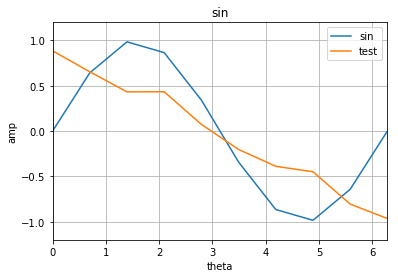

test next
epoch: 20/50 train loss: 0.1695522427558899 test loss: 0.1920590102672577
epoch: 30/50 train loss: 0.11130593046545982 test loss: 0.10742871463298798
test !!
theta is [ 0.          0.6981317   1.3962634   2.0943951   2.7925268   3.4906585
  4.1887902   4.88692191  5.58505361  6.28318531]
test result
[[ 0.69603944]
 [ 0.72728103]
 [ 0.71538693]
 [ 0.57940084]
 [ 0.30480155]
 [-0.09531172]
 [-0.44123805]
 [-0.70975119]
 [-0.7648297 ]
 [-0.83701003]]


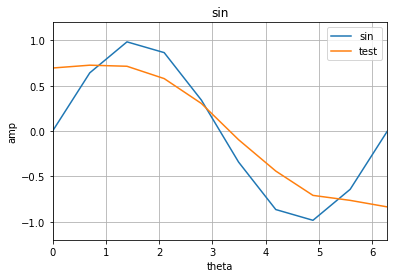

test next
epoch: 40/50 train loss: 0.04651728682219982 test loss: 0.05170883983373642
epoch: 50/50 train loss: 0.024611382628791034 test loss: 0.09508359432220459
test !!
theta is [ 0.          0.6981317   1.3962634   2.0943951   2.7925268   3.4906585
  4.1887902   4.88692191  5.58505361  6.28318531]
test result
[[ 0.12682652]
 [ 0.6476838 ]
 [ 0.95883971]
 [ 0.94879049]
 [ 0.40299672]
 [-0.35235691]
 [-0.73047554]
 [-0.7945618 ]
 [-0.60826832]
 [-0.59083092]]


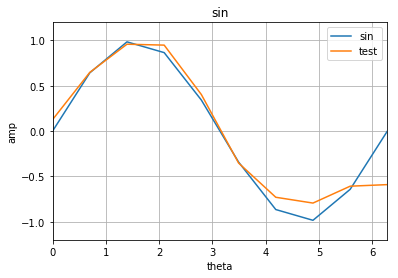

test next
end
実行時間: 192sec


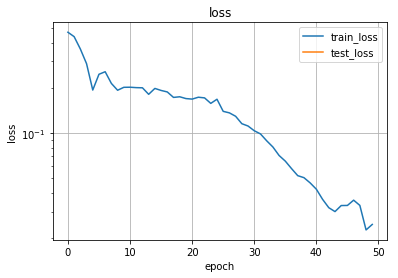

In [4]:

# main
if __name__ == "__main__":

    # 学習データ
    N = 100
    x_train, y_train = get_dataset(N)

    # テストデータ
    N_test = 10
    x_test, y_test = get_dataset(N_test)
        
    # 学習パラメータ
    batchsize = 10
    n_epoch = 50
    n_units = 100

    print("x_train ", x_train.shape)
    
    # モデル作成
    model = RNN_Model(n_units)
    model_loss = LossFuncL(model)
    model_loss.compute_accuracy = False  # we only want the perplexity
    for param in model_loss.params():
        data = param.data
        data[:] = np.random.uniform(-0.1, 0.1, data.shape)
#     if args.gpu >= 0:
#         cuda.get_device(args.gpu).use()
#         model_loss.to_gpu()
    
    optimizer = optimizers.Adam()
    optimizer.setup(model_loss)

    # 学習ループ
    train_losses =[]
    test_losses =[]
    print("start...")
    start_time = time.time()
    #n_epochが500だと500回まわる
    for epoch in range(1, n_epoch + 1):

        # training
        perm = np.random.permutation(N)
        sum_loss = 0
        #batchsizeが100個のデータに対して10個ずつまわる
        for i in range(0, N, batchsize):
            
            x_batch = x_train[perm[i:i + batchsize]].astype(np.float32)
            y_batch = y_train[perm[i:i + batchsize]].astype(np.float32)
            
            model_loss.zerograds()
            loss = model_loss(x_batch,y_batch)
            sum_loss += loss.data * batchsize
            loss.backward()
            optimizer.update()

        average_loss = sum_loss / N
        train_losses.append(average_loss)

        # test
#         loss = model_loss(x_test,y_test)
#         test_losses.append(loss.data)

        # 学習過程を出力
        if epoch % 10 == 0:
            print("epoch: {}/{} train loss: {} test loss: {}".format(epoch, n_epoch, average_loss, loss.data))

        # 学習結果のグラフ作成
        if epoch in [10, 30, 50]:
            print("test !!")
            theta = np.linspace(0, 2 * np.pi, N_test)
            sin = np.sin(theta)
            test = model.get_predata(theta)
            
            print("theta is", theta)
            print("test result")
            print(test.data)
            
            plt.plot(theta, sin, label = "sin")
            plt.plot(theta, test.data, label = "test")
            plt.legend()
            plt.grid(True)
            plt.xlim(0, 2 * np.pi)
            plt.ylim(-1.2, 1.2)
            plt.title("sin")
            plt.xlabel("theta")
            plt.ylabel("amp")
            plt.show()
#             plt.savefig("fig/fig_sin_epoch{}.png".format(epoch)) # figフォルダが存在していることを前提
            plt.clf() #グラフ初期化
            print("test next")

    print("end")

    interval = int(time.time() - start_time)
    print("実行時間: {}sec".format(interval))


    # 誤差のグラフ作成
    plt.plot(train_losses, label = "train_loss")
    plt.plot(test_losses, label = "test_loss")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.title("loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
#     plt.savefig("fig/fig_loss.png") # figフォルダが存在していることを前提
#     plt.clf()
    plt.show()
